In [2]:
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-23 01:44:28.460303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

# Загружаем массивы из папки cnn_data
X_train_cnn = np.load('cnn_data_MULTICLASS/X_train_cnn.npy')
X_val_cnn = np.load('cnn_data_MULTICLASS/X_val_cnn.npy')
X_test_cnn = np.load('cnn_data_MULTICLASS/X_test_cnn.npy')

y_train = np.load('cnn_data_MULTICLASS/y_train.npy')
y_val = np.load('cnn_data_MULTICLASS/y_val.npy')
y_test = np.load('cnn_data_MULTICLASS/y_test.npy')

In [4]:
X_train_cnn.shape


(999, 25, 16, 1)

In [4]:
X_train_cnn.shape[1:]  # (25, num_features)


(25, 16, 1)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm
import numpy as np

# Параметры модели
input_shape = X_train_cnn.shape[1:]  # (25кадров, 16 признаков, 1канал)
num_classes = 5  # ['hu', 'hg', 'hs', 'hm', 'hi']
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Создаем CNN для извлечения признаков (БЕЗ ИЗМЕНЕНИЙ)
def create_cnn_feature_extractor(input_shape):
    model = models.Sequential(name="CNN_Feature_Extractor")
    
    # Блок 1: Извлечение низкоуровневых признаков
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                           input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.2, name='dropout1'))
    
    # Блок 2: Извлечение среднеуровневых признаков
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    
    # Блок 3: Извлечение высокоуровневых признаков
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    
    # Слой извлечения признаков (около 5 признаков)
    model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
    model.add(layers.Dropout(0.4, name='dropout3'))
    model.add(layers.Dense(5, activation=None, name='features'))  # 5 признаков без активации
    
    return model

# Создаем полную модель с многометочной классификационной головкой
def create_full_multilabel_model(input_shape, num_classes):
    # Извлекатель признаков (БЕЗ ИЗМЕНЕНИЙ)
    feature_extractor = create_cnn_feature_extractor(input_shape)
    
    # Классификационная головка для многометочной классификации
    classifier_head = models.Sequential([
        layers.Dense(16, activation='relu', name='classifier_dense1'),
        layers.Dropout(0.3, name='classifier_dropout1'),
        layers.Dense(8, activation='relu', name='classifier_dense2'),
        # 5 выходных нейронов с sigmoid активацией для каждой метки
        layers.Dense(num_classes, activation='sigmoid', name='output')
    ], name="Multilabel_Classifier_Head")
    
    # Полная модель
    inputs = layers.Input(shape=input_shape)
    features = feature_extractor(inputs)
    output = classifier_head(features)
    
    full_model = Model(inputs=inputs, outputs=output, name="CNN_Multilabel_Classifier")
    
    return full_model, feature_extractor

# Кастомный callback с одним прогресс-баром
class SingleProgressBarCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.current_epoch = 0
        self.pbar = None
        
    def on_train_begin(self, logs=None):
        # Создаем один прогресс-бар на все обучение
        self.pbar = tqdm(total=self.total_epochs, 
                        desc="Обучение модели", 
                        unit="эпоха",
                        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1
        
        # Формируем строку с метриками
        metrics_str = f"Эпоха {self.current_epoch}/{self.total_epochs}"
        if logs:
            metrics_str += f" - loss: {logs.get('loss', 0):.4f}"
            metrics_str += f", val_loss: {logs.get('val_loss', 0):.4f}"
            metrics_str += f", acc: {logs.get('accuracy', 0):.4f}"
        
        # Обновляем описание прогресс-бара
        self.pbar.set_description(metrics_str)
        self.pbar.update(1)
        
    def on_train_end(self, logs=None):
        self.pbar.close()

# Создаем модель
model, feature_extractor = create_full_multilabel_model(input_shape, num_classes)

# Компилируем модель
model.compile(
    optimizer=Adam(learning_rate=0.001),
    # binary_crossentropy работает для многометочной классификации
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5),
        tf.keras.metrics.Recall(thresholds=0.5)
    ]
)

# Выводим архитектуру модели
print("\n" + "="*50)
print("АРХИТЕКТУРА МОДЕЛИ")
print("="*50)
model.summary()

# Дополнительно покажем архитектуру извлекателя признаков
print("\n" + "="*50)
print("АРХИТЕКТУРА ИЗВЛЕКАТЕЛЯ ПРИЗНАКОВ")
print("="*50)
feature_extractor.summary()

# Callbacks для обучения с нашим кастомным прогресс-баром
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0),
    ModelCheckpoint('best_multilabel_model.h5', monitor='val_loss', save_best_only=True, verbose=0),
    SingleProgressBarCallback(total_epochs=50)  # Наш кастомный прогресс-бар
]

# Обучение модели
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ")
print("="*50)

# Устанавливаем verbose=0, чтобы не было стандартного вывода Keras
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=0  # Важно: отключаем стандартный вывод
)

print("\n" + "="*50)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО")
print("="*50)

# Оценка на тестовых данных
print("\n" + "="*50)
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)

# Прогресс-бар для оценки
print("Выполняется оценка на тестовых данных...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Дополнительный анализ по каждой метке
print("\n" + "="*50)
print("АНАЛИЗ ПО КАЖДОЙ МЕТКЕ")
print("="*50)

# Прогресс-бар для предсказаний
print("Выполняется предсказание на тестовых данных...")
y_pred_proba = model.predict(X_test_cnn, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Названия классов
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

# Оцениваем каждую метку отдельно
for i in range(num_classes):
    y_true_label = y_test[:, i]
    y_pred_label = y_pred[:, i]
    
    # Базовые метрики
    accuracy = (y_true_label == y_pred_label).mean()
    precision = (y_true_label[y_pred_label == 1] == 1).mean() if (y_pred_label == 1).sum() > 0 else 0
    recall = (y_pred_label[y_true_label == 1] == 1).mean() if (y_true_label == 1).sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_names[i]}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Распределение: 0={(y_true_label == 0).sum()}, 1={(y_true_label == 1).sum()}")

Input shape: (25, 16, 1)
Number of classes: 5


W0000 00:00:1766350525.678215  101163 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



АРХИТЕКТУРА МОДЕЛИ


Model: "CNN_Multilabel_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Feature_Extractor           │ (None, 5)              │        97,861 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Multilabel_Classifier_Head      │ (None, 5)              │           277 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,138 (383.35 KB)

 Trainable params: 97,690 (381.60 KB)

 Non-trainable params: 448 (1.75 KB)


АРХИТЕКТУРА ИЗВЛЕКАТЕЛЯ ПРИЗНАКОВ


Model: "CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 25, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 12, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 6, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,861 (382.27 KB)

 Trainable params: 97,413 (380.52 KB)

 Non-trainable params: 448 (1.75 KB)


НАЧАЛО ОБУЧЕНИЯ


Обучение модели:   0%|          | 0/50 [00:00<?]WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
Эпоха 1/50 - loss: 0.6780, val_loss: 0.6669, acc: 0.4685:   2%|▏         | 1/50 [00:04<03:47]WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
Эпоха 2/50 - loss: 0.5959, val_loss: 0.5516, acc: 0.4474:   4%|▍         | 2/50 [00:05<01:54]WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead t


ОБУЧЕНИЕ ЗАВЕРШЕНО

ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ
Выполняется оценка на тестовых данных...
Test Loss: 0.1088
Test Accuracy: 0.1977
Test Precision: 0.7561
Test Recall: 0.5569

АНАЛИЗ ПО КАЖДОЙ МЕТКЕ
Выполняется предсказание на тестовых данных...

hu:
  Accuracy:  0.9771
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=598, 1=14

hg:
  Accuracy:  0.9935
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=608, 1=4

hs:
  Accuracy:  0.9559
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=585, 1=27

hm:
  Accuracy:  0.9690
  Precision: 0.4615
  Recall:    0.3333
  F1-score:  0.3871
  Распределение: 0=594, 1=18

hi:
  Accuracy:  0.9346
  Precision: 0.7909
  Recall:    0.8365
  F1-score:  0.8131
  Распределение: 0=508, 1=104


Input shape: (25, 16, 1)
Number of classes: 5

АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ
hu:
  Train: 22.0/999 (2.2%)
  Val:   9.0/429 (2.1%)
  Test:  14.0/612 (2.3%)
hg:
  Train: 8.0/999 (0.8%)
  Val:   3.0/429 (0.7%)
  Test:  4.0/612 (0.7%)
hs:
  Train: 44.0/999 (4.4%)
  Val:   19.0/429 (4.4%)
  Test:  27.0/612 (4.4%)
hm:
  Train: 29.0/999 (2.9%)
  Val:   13.0/429 (3.0%)
  Test:  18.0/612 (2.9%)
hi:
  Train: 169.0/999 (16.9%)
  Val:   72.0/429 (16.8%)
  Test:  104.0/612 (17.0%)
hu: вес класса 0=0.02, вес класса 1=0.98
hg: вес класса 0=0.01, вес класса 1=0.99
hs: вес класса 0=0.04, вес класса 1=0.96
hm: вес класса 0=0.03, вес класса 1=0.97
hi: вес класса 0=0.17, вес класса 1=0.83

НАЧАЛО ОБУЧЕНИЯ
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2924 - auc: 0.5788 - f1_score: 0.0662 - loss: 0.3780
Epoch 1: val_f1_score improved from None to 0.00000, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3033 - auc: 0.5838 - f1_score: 0.0972 - loss: 0.3572 - val_accuracy: 0.0233 - val_auc: 0.5557 - val_f1_score: 0.0000e+00 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 2/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3001 - auc: 0.5615 - f1_score: 0.1833 - loss: 0.3089
Epoch 2: val_f1_score did not improve from 0.00000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3053 - auc: 0.5801 - f1_score: 0.2037 - loss: 0.2917 - val_accuracy: 0.3333 - val_auc: 0.5958 - val_f1_score: 0.0000e+00 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 3/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3364 - auc: 0.6444 - f1_score: 0.2437 - loss: 0.2452
Epoch 3: val_f1_score did not improve from 0.00000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3093 - auc: 0.6506 - f1_score: 0.2534 - loss: 0.2348 - val_accuracy: 0.5781 - val_auc: 0.6684 - val_f1_score: 0.0000e+00 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3093 - auc: 0.8790 - f1_score: 0.4144 - loss: 0.1332 - val_accuracy: 0.4802 - val_auc: 0.8747 - val_f1_score: 0.1587 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 9/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3117 - auc: 0.8427 - f1_score: 0.4834 - loss: 0.1226
Epoch 9: val_f1_score improved from 0.15873 to 0.29412, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2853 - auc: 0.8739 - f1_score: 0.4715 - loss: 0.1274 - val_accuracy: 0.4289 - val_auc: 0.8851 - val_f1_score: 0.2941 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 10/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3249 - auc: 0.8806 - f1_score: 0.5063 - loss: 0.1198
Epoch 10: val_f1_score improved from 0.29412 to 0.36620, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3133 - auc: 0.9008 - f1_score: 0.5166 - loss: 0.1203 - val_accuracy: 0.3753 - val_auc: 0.9034 - val_f1_score: 0.3662 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 11/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3370 - auc: 0.9096 - f1_score: 0.5126 - loss: 0.1193
Epoch 11: val_f1_score improved from 0.36620 to 0.47059, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3233 - auc: 0.9343 - f1_score: 0.5172 - loss: 0.1106 - val_accuracy: 0.3939 - val_auc: 0.9185 - val_f1_score: 0.4706 - val_loss: 0.1135 - learning_rate: 0.0010
Epoch 12/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3226 - auc: 0.8940 - f1_score: 0.6243 - loss: 0.1113
Epoch 12: val_f1_score improved from 0.47059 to 0.50000, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3163 - auc: 0.9108 - f1_score: 0.6172 - loss: 0.1049 - val_accuracy: 0.3077 - val_auc: 0.9368 - val_f1_score: 0.5000 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 13/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3080 - auc: 0.8925 - f1_score: 0.6033 - loss: 0.0971
Epoch 13: val_f1_score improved from 0.50000 to 0.53086, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3243 - auc: 0.9267 - f1_score: 0.5874 - loss: 0.1035 - val_accuracy: 0.2681 - val_auc: 0.9471 - val_f1_score: 0.5309 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 14/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3020 - auc: 0.8862 - f1_score: 0.5996 - loss: 0.0908
Epoch 14: val_f1_score improved from 0.53086 to 0.69565, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2963 - auc: 0.9453 - f1_score: 0.6115 - loss: 0.0942 - val_accuracy: 0.3240 - val_auc: 0.9374 - val_f1_score: 0.6957 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 15/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3480 - auc: 0.9343 - f1_score: 0.5880 - loss: 0.0910
Epoch 15: val_f1_score did not improve from 0.69565
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3273 - auc: 0.9489 - f1_score: 0.5619 - loss: 0.0944 - val_accuracy: 0.3566 - val_auc: 0.9444 - val_f1_score: 0.6400 - val_loss: 0.0878 - learning_rate: 0.0010
Epoch 16/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3569 - auc: 0.9568 - f1_score: 0.6782 - loss: 0.0883
Epoch 16: val_f1_score did not improve from 0.69565
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3303 - auc: 0.9603 - f1_score: 0.6608 - loss: 0.0850 - val_accuracy: 0.3310 - val_auc: 0.9588 - val_f1_score: 0.6818 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 17/100
3

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3193 - auc: 0.9615 - f1_score: 0.6623 - loss: 0.0848 - val_accuracy: 0.3077 - val_auc: 0.9686 - val_f1_score: 0.7135 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 18/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3134 - auc: 0.9305 - f1_score: 0.6658 - loss: 0.0844
Epoch 18: val_f1_score did not improve from 0.71351
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3083 - auc: 0.9675 - f1_score: 0.6895 - loss: 0.0784 - val_accuracy: 0.3310 - val_auc: 0.9586 - val_f1_score: 0.6915 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 19/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3358 - auc: 0.8595 - f1_score: 0.6768 - loss: 0.0686
Epoch 19: val_f1_score did not improve from 0.71351
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3373 - auc: 0.9684 - f1_score: 0.6858 - loss: 0.0744 - val_accuracy: 0.3124 - val_auc: 0.9713 - val_f1_score: 0.6703 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 20/100
3

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3423 - auc: 0.9779 - f1_score: 0.7229 - loss: 0.0672 - val_accuracy: 0.2890 - val_auc: 0.9691 - val_f1_score: 0.7255 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 22/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3559 - auc: 0.9645 - f1_score: 0.7293 - loss: 0.0686
Epoch 22: val_f1_score improved from 0.72549 to 0.73367, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3493 - auc: 0.9730 - f1_score: 0.6994 - loss: 0.0736 - val_accuracy: 0.3240 - val_auc: 0.9624 - val_f1_score: 0.7337 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 23/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3890 - auc: 0.9517 - f1_score: 0.7380 - loss: 0.0561
Epoch 23: val_f1_score did not improve from 0.73367
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3814 - auc: 0.9842 - f1_score: 0.7348 - loss: 0.0630 - val_accuracy: 0.3636 - val_auc: 0.9694 - val_f1_score: 0.7208 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 24/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3652 - auc: 0.9492 - f1_score: 0.7550 - loss: 0.0668
Epoch 24: val_f1_score improved from 0.73367 to 0.76847, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3564 - auc: 0.9813 - f1_score: 0.7454 - loss: 0.0633 - val_accuracy: 0.3660 - val_auc: 0.9705 - val_f1_score: 0.7685 - val_loss: 0.0670 - learning_rate: 0.0010
Epoch 25/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3798 - auc: 0.9735 - f1_score: 0.7348 - loss: 0.0563
Epoch 25: val_f1_score did not improve from 0.76847
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3614 - auc: 0.9843 - f1_score: 0.7683 - loss: 0.0557 - val_accuracy: 0.3986 - val_auc: 0.9585 - val_f1_score: 0.7317 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 26/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3506 - auc: 0.9461 - f1_score: 0.7704 - loss: 0.0519
Epoch 26: val_f1_score did not improve from 0.76847
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3774 - auc: 0.9821 - f1_score: 0.7860 - loss: 0.0555 - val_accuracy: 0.5221 - val_auc: 0.9573 - val_f1_score: 0.7523 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 27/100
2

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4044 - auc: 0.9849 - f1_score: 0.7733 - loss: 0.0570 - val_accuracy: 0.4709 - val_auc: 0.9613 - val_f1_score: 0.7814 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 29/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3793 - auc: 0.9701 - f1_score: 0.8284 - loss: 0.0463
Epoch 29: val_f1_score did not improve from 0.78140
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3954 - auc: 0.9840 - f1_score: 0.8098 - loss: 0.0517 - val_accuracy: 0.4615 - val_auc: 0.9574 - val_f1_score: 0.7547 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 30/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3878 - auc: 0.9839 - f1_score: 0.8619 - loss: 0.0409
Epoch 30: val_f1_score did not improve from 0.78140
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3904 - auc: 0.9867 - f1_score: 0.8353 - loss: 0.0466 - val_accuracy: 0.3916 - val_auc: 0.9707 - val_f1_score: 0.7814 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 31/100
2

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3914 - auc: 0.9906 - f1_score: 0.8482 - loss: 0.0431 - val_accuracy: 0.4009 - val_auc: 0.9580 - val_f1_score: 0.8120 - val_loss: 0.0662 - learning_rate: 0.0010
Epoch 36/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3829 - auc: 0.9764 - f1_score: 0.8721 - loss: 0.0389
Epoch 36: val_f1_score did not improve from 0.81197
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3884 - auc: 0.9947 - f1_score: 0.8583 - loss: 0.0371 - val_accuracy: 0.3916 - val_auc: 0.9545 - val_f1_score: 0.7611 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 37/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4071 - auc: 0.9697 - f1_score: 0.8708 - loss: 0.0385
Epoch 37: val_f1_score did not improve from 0.81197
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3904 - auc: 0.9930 - f1_score: 0.8560 - loss: 0.0407 - val_accuracy: 0.3730 - val_auc: 0.9590 - val_f1_score: 0.7982 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 38/100
2

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4264 - auc: 0.9977 - f1_score: 0.8964 - loss: 0.0266 - val_accuracy: 0.4196 - val_auc: 0.9588 - val_f1_score: 0.8128 - val_loss: 0.0678 - learning_rate: 5.0000e-04
Epoch 50/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3974 - auc: 0.9907 - f1_score: 0.9002 - loss: 0.0279
Epoch 50: val_f1_score did not improve from 0.81279
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4044 - auc: 0.9978 - f1_score: 0.9063 - loss: 0.0257 - val_accuracy: 0.4196 - val_auc: 0.9500 - val_f1_score: 0.7788 - val_loss: 0.0750 - learning_rate: 5.0000e-04
Epoch 51/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4079 - auc: 0.9823 - f1_score: 0.9120 - loss: 0.0283
Epoch 51: val_f1_score did not improve from 0.81279
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4174 - auc: 0.9959 - f1_score: 0.9198 - loss: 0.0268 - val_accuracy: 0.4289 - val_auc: 0.9558 - val_f1_score: 0.8000 - val_loss: 0.0701 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4194 - auc: 0.9984 - f1_score: 0.9266 - loss: 0.0229 - val_accuracy: 0.4009 - val_auc: 0.9502 - val_f1_score: 0.8186 - val_loss: 0.0769 - learning_rate: 5.0000e-04
Epoch 54/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4070 - auc: 0.9837 - f1_score: 0.9115 - loss: 0.0247
Epoch 54: val_f1_score did not improve from 0.81860
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3884 - auc: 0.9974 - f1_score: 0.9275 - loss: 0.0244 - val_accuracy: 0.3916 - val_auc: 0.9509 - val_f1_score: 0.8093 - val_loss: 0.0758 - learning_rate: 5.0000e-04
Epoch 55/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4156 - auc: 0.9541 - f1_score: 0.9175 - loss: 0.0226
Epoch 55: val_f1_score did not improve from 0.81860
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4024 - auc: 0.9983 - f1_score: 0.9295 - loss: 0.0216 - val_accuracy: 0.3963 - val_auc: 0.9444 - val_f1_score: 0.8018 - val_loss: 0.0790 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4034 - auc: 0.9977 - f1_score: 0.8975 - loss: 0.0274 - val_accuracy: 0.4545 - val_auc: 0.9496 - val_f1_score: 0.8319 - val_loss: 0.0696 - learning_rate: 5.0000e-04
Epoch 59/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3932 - auc: 0.9789 - f1_score: 0.9412 - loss: 0.0196
Epoch 59: val_f1_score did not improve from 0.83186
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3884 - auc: 0.9988 - f1_score: 0.9236 - loss: 0.0209 - val_accuracy: 0.3916 - val_auc: 0.9446 - val_f1_score: 0.8214 - val_loss: 0.0709 - learning_rate: 5.0000e-04
Epoch 60/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3743 - auc: 0.9344 - f1_score: 0.9245 - loss: 0.0192
Epoch 60: val_f1_score did not improve from 0.83186
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3914 - auc: 0.9982 - f1_score: 0.9280 - loss: 0.0207 - val_accuracy: 0.4219 - val_auc: 0.9365 - val_f1_score: 0.8263 - val_loss: 0.0747 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4254 - auc: 0.9989 - f1_score: 0.9389 - loss: 0.0179 - val_accuracy: 0.3986 - val_auc: 0.9337 - val_f1_score: 0.8341 - val_loss: 0.0840 - learning_rate: 5.0000e-04
Epoch 68/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3847 - auc: 0.9661 - f1_score: 0.9509 - loss: 0.0191
Epoch 68: val_f1_score did not improve from 0.83408
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4064 - auc: 0.9978 - f1_score: 0.9448 - loss: 0.0202 - val_accuracy: 0.4172 - val_auc: 0.9467 - val_f1_score: 0.8341 - val_loss: 0.0792 - learning_rate: 5.0000e-04
Epoch 69/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4314 - auc: 0.9577 - f1_score: 0.9501 - loss: 0.0177
Epoch 69: val_f1_score did not improve from 0.83408
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4294 - auc: 0.9982 - f1_score: 0.9423 - loss: 0.0191 - val_accuracy: 0.4312 - val_auc: 0.9405 - val_f1_score: 0.8070 - val_loss: 0.0826 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4364 - auc: 0.9991 - f1_score: 0.9497 - loss: 0.0159 - val_accuracy: 0.4545 - val_auc: 0.9423 - val_f1_score: 0.8356 - val_loss: 0.0779 - learning_rate: 5.0000e-04
Epoch 71/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4415 - auc: 0.9732 - f1_score: 0.9790 - loss: 0.0117
Epoch 71: val_f1_score did not improve from 0.83556
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4254 - auc: 0.9993 - f1_score: 0.9662 - loss: 0.0135 - val_accuracy: 0.4382 - val_auc: 0.9477 - val_f1_score: 0.8319 - val_loss: 0.0806 - learning_rate: 5.0000e-04
Epoch 72/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4276 - auc: 0.9717 - f1_score: 0.9406 - loss: 0.0153
Epoch 72: val_f1_score did not improve from 0.83556
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4194 - auc: 0.9964 - f1_score: 0.9373 - loss: 0.0176 - val_accuracy: 0.4476 - val_auc: 0.9512 - val_f1_score: 0.8182 - val_loss: 0.0787 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4484 - auc: 0.9984 - f1_score: 0.9251 - loss: 0.0189 - val_accuracy: 0.4569 - val_auc: 0.9466 - val_f1_score: 0.8407 - val_loss: 0.0675 - learning_rate: 5.0000e-04
Epoch 79/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4310 - auc: 0.9409 - f1_score: 0.9370 - loss: 0.0191
Epoch 79: val_f1_score did not improve from 0.84071
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4284 - auc: 0.9990 - f1_score: 0.9401 - loss: 0.0186 - val_accuracy: 0.4545 - val_auc: 0.9366 - val_f1_score: 0.8273 - val_loss: 0.0722 - learning_rate: 5.0000e-04
Epoch 80/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4468 - auc: 0.9541 - f1_score: 0.9397 - loss: 0.0169
Epoch 80: val_f1_score did not improve from 0.84071
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4474 - auc: 0.9992 - f1_score: 0.9478 - loss: 0.0159 - val_accuracy: 0.4685 - val_auc: 0.9379 - val_f1_score: 0.8186 - val_loss: 0.0809 - learning_rate: 5.0000e-04
Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4424 - auc: 0.9991 - f1_score: 0.9478 - loss: 0.0156 - val_accuracy: 0.4359 - val_auc: 0.9243 - val_f1_score: 0.8444 - val_loss: 0.0746 - learning_rate: 5.0000e-04
Epoch 83/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4491 - auc: 0.9815 - f1_score: 0.9581 - loss: 0.0159
Epoch 83: val_f1_score improved from 0.84444 to 0.85106, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4384 - auc: 0.9951 - f1_score: 0.9534 - loss: 0.0168 - val_accuracy: 0.4289 - val_auc: 0.9361 - val_f1_score: 0.8511 - val_loss: 0.0723 - learning_rate: 5.0000e-04
Epoch 84/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4370 - auc: 0.9670 - f1_score: 0.9563 - loss: 0.0139
Epoch 84: val_f1_score improved from 0.85106 to 0.85217, saving model to best_multilabel_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4154 - auc: 0.9991 - f1_score: 0.9627 - loss: 0.0134 - val_accuracy: 0.4336 - val_auc: 0.9439 - val_f1_score: 0.8522 - val_loss: 0.0709 - learning_rate: 5.0000e-04
Epoch 85/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4203 - auc: 0.9524 - f1_score: 0.9444 - loss: 0.0146
Epoch 85: val_f1_score did not improve from 0.85217
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4414 - auc: 0.9986 - f1_score: 0.9358 - loss: 0.0179 - val_accuracy: 0.4429 - val_auc: 0.9432 - val_f1_score: 0.8297 - val_loss: 0.0807 - learning_rate: 5.0000e-04
Epoch 86/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4057 - auc: 0.9983 - f1_score: 0.9212 - loss: 0.0245
Epoch 86: val_f1_score did not improve from 0.85217
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4184 - auc: 0.9988 - f1_score: 0.9534 - loss: 0.0155 - val_accuracy: 0.4103 - val_auc: 0.9447 - val_f1_score: 0.8240 - val_loss: 0.0843 - learning_rate: 5.0000e-04
Ep

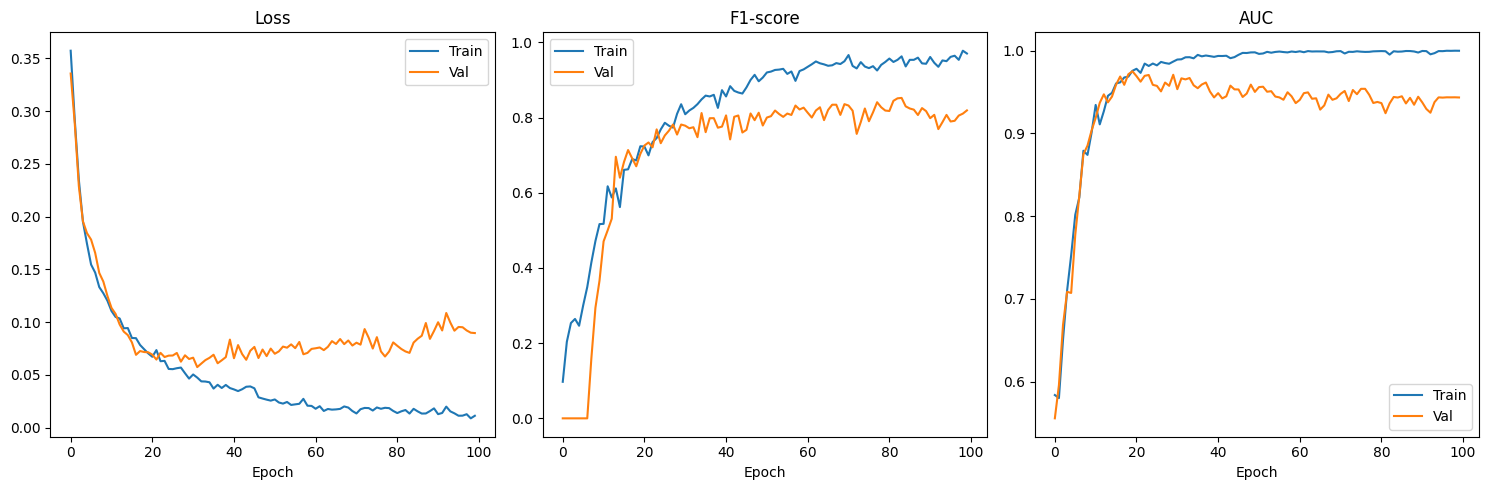

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

# Параметры модели
input_shape = X_train_cnn.shape[1:]  # (25кадров, 16 признаков, 1канал)
num_classes = 5  # ['hu', 'hg', 'hs', 'hm', 'hi']

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# ==================== АНАЛИЗ ДИСБАЛАНСА ====================
print("\n" + "="*50)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ")
print("="*50)

class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

for i, name in enumerate(class_names):
    pos_count_train = y_train[:, i].sum()
    pos_count_val = y_val[:, i].sum()
    pos_count_test = y_test[:, i].sum()
    
    print(f"{name}:")
    print(f"  Train: {pos_count_train}/{len(y_train)} ({pos_count_train/len(y_train)*100:.1f}%)")
    print(f"  Val:   {pos_count_val}/{len(y_val)} ({pos_count_val/len(y_val)*100:.1f}%)")
    print(f"  Test:  {pos_count_test}/{len(y_test)} ({pos_count_test/len(y_test)*100:.1f}%)")

# ==================== КАСТОМНАЯ ФУНКЦИЯ ПОТЕРЬ (ИСПРАВЛЕННАЯ) ====================
def weighted_binary_crossentropy(y_true, y_pred):
    """
    Взвешенная бинарная кросс-энтропия для борьбы с дисбалансом
    """
    # Расчет весов для каждого класса
    pos_weight = 10.0  # Вес для положительного класса
    neg_weight = 1.0   # Вес для отрицательного класса
    
    # Бинарная кросс-энтропия с учетом весов
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Применяем веса - исправляем размерность
    weights = y_true * pos_weight + (1 - y_true) * neg_weight
    
    # Усредняем по классам, потом по батчу
    weighted_bce = bce * weights
    return tf.reduce_mean(weighted_bce)

# Альтернатива: встроенная взвешенная функция потерь
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss для борьбы с дисбалансом классов
    Подходит для случаев с большим количеством негативных примеров
    """
    def loss(y_true, y_pred):
        # Избегаем log(0)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Вычисляем cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Вычисляем веса для focal loss
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Focal loss
        focal_loss = alpha_t * (1 - p_t) ** gamma * cross_entropy
        
        return tf.reduce_mean(focal_loss)
    
    return loss

# ==================== УПРОЩЕННАЯ F1-SCORE МЕТРИКА ====================
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# ==================== ПРОСТАЯ МОДЕЛЬ С УЧЕТОМ ДИСБАЛАНСА ====================
def create_simple_multilabel_model(input_shape, num_classes):
    # Вход
    inputs = layers.Input(shape=input_shape)
    
    # Извлекатель признаков (ваша оригинальная архитектура)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Классификационная головка
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(5, activation=None)(x)  # 5 признаков
    
    # Добавляем выходной слой с bias initialization для редких классов
    outputs = layers.Dense(
        num_classes, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        bias_initializer=tf.keras.initializers.Constant(-1.0)  # Смещение для редких классов
    )(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ==================== СБОРКА И КОМПИЛЯЦИЯ МОДЕЛИ ====================
model = create_simple_multilabel_model(input_shape, num_classes)

# Оптимизатор
optimizer = Adam(learning_rate=0.001)

# Вычисляем веса классов на основе частот
class_weights = {}
for i in range(num_classes):
    pos_samples = y_train[:, i].sum()
    neg_samples = len(y_train) - pos_samples
    
    # Вес для положительного класса обратно пропорционален его частоте
    weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
    weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
    
    # Нормализуем
    total = weight_for_class_0 + weight_for_class_1
    weight_for_class_0 /= total
    weight_for_class_1 /= total
    
    class_weights[i] = {0: weight_for_class_0, 1: weight_for_class_1}
    
    print(f"{class_names[i]}: вес класса 0={weight_for_class_0:.2f}, вес класса 1={weight_for_class_1:.2f}")

# Простая функция потерь с весами
def simple_weighted_loss(y_true, y_pred):
    # Используем стандартную бинарную кросс-энтропию
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Среднее по всем классам и образцам
    return tf.reduce_mean(bce)

model.compile(
    optimizer=optimizer,
    loss=simple_weighted_loss,  # Используем простую функцию
    metrics=[
        'accuracy',
        F1Score(threshold=0.5, name='f1_score'),
        tf.keras.metrics.AUC(multi_label=True, name='auc')
    ]
)

# ==================== CALLBACKS ====================
callbacks = [
    EarlyStopping(
        monitor='val_f1_score',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_multilabel_model.h5',
        monitor='val_f1_score',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# ==================== ОБУЧЕНИЕ С ВЕСАМИ КЛАССОВ ====================
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ")
print("="*50)

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ==================== ОЦЕНКА ====================
print("\n" + "="*50)
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)

# Оценка со стандартным порогом 0.5
test_results = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nСтандартный порог (0.5):")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"F1-score: {test_results[2]:.4f}")
print(f"AUC: {test_results[3]:.4f}")

# ==================== ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ ====================
print("\n" + "="*50)
print("ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ")
print("="*50)

def find_optimal_thresholds(model, X_val, y_val, class_names):
    """Находит оптимальные пороги для каждого класса"""
    y_pred_proba = model.predict(X_val, verbose=0)
    thresholds = []
    
    for i in range(len(class_names)):
        y_true = y_val[:, i]
        y_prob = y_pred_proba[:, i]
        
        best_threshold = 0.5
        best_f1 = 0
        
        # Перебираем пороги от 0.1 до 0.9
        for threshold in np.arange(0.05, 0.95, 0.05):
            y_pred = (y_prob > threshold).astype(int)
            
            # Вычисляем F1-score
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            
            if tp + fp > 0 and tp + fn > 0:
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
                f1 = 2 * precision * recall / (precision + recall)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
        
        thresholds.append(best_threshold)
        print(f"{class_names[i]}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
    
    return thresholds

# Находим оптимальные пороги
optimal_thresholds = find_optimal_thresholds(model, X_val_cnn, y_val, class_names)

# ==================== ОЦЕНКА С ОПТИМАЛЬНЫМИ ПОРОГАМИ ====================
print("\n" + "="*50)
print("ОЦЕНКА С ОПТИМАЛЬНЫМИ ПОРОГАМИ")
print("="*50)

y_pred_proba = model.predict(X_test_cnn, verbose=0)

for i, name in enumerate(class_names):
    threshold = optimal_thresholds[i]
    y_true = y_test[:, i]
    y_pred = (y_pred_proba[:, i] > threshold).astype(int)
    
    # Вычисляем метрики
    accuracy = np.mean(y_true == y_pred)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    print(f"\n{name} (порог={threshold:.2f}):")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Положительных: {y_true.sum()}/{len(y_true)}")

# ==================== ВИЗУАЛИЗАЦИЯ ====================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# F1-score
axes[1].plot(history.history['f1_score'], label='Train')
axes[1].plot(history.history['val_f1_score'], label='Val')
axes[1].set_title('F1-score')
axes[1].set_xlabel('Epoch')
axes[1].legend()

# AUC
axes[2].plot(history.history['auc'], label='Train')
axes[2].plot(history.history['val_auc'], label='Val')
axes[2].set_title('AUC')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout()
plt.show()




АНАЛИЗ ИТОГОВЫХ РЕЗУЛЬТАТОВ

hu:
  Порог: 0.40
  F1-score: 0.6667
  Precision: 0.8000
  Recall: 0.5714
  Accuracy: 0.9869
  TP/FP/FN: 8/2/6

hg:
  Порог: 0.60
  F1-score: 0.8571
  Precision: 1.0000
  Recall: 0.7500
  Accuracy: 0.9984
  TP/FP/FN: 3/0/1

hs:
  Порог: 0.60
  F1-score: 0.4889
  Precision: 0.6111
  Recall: 0.4074
  Accuracy: 0.9624
  TP/FP/FN: 11/7/16

hm:
  Порог: 0.25
  F1-score: 0.7879
  Precision: 0.8667
  Recall: 0.7222
  Accuracy: 0.9886
  TP/FP/FN: 13/2/5

hi:
  Порог: 0.30
  F1-score: 0.8545
  Precision: 0.8349
  Recall: 0.8750
  Accuracy: 0.9493
  TP/FP/FN: 91/18/13


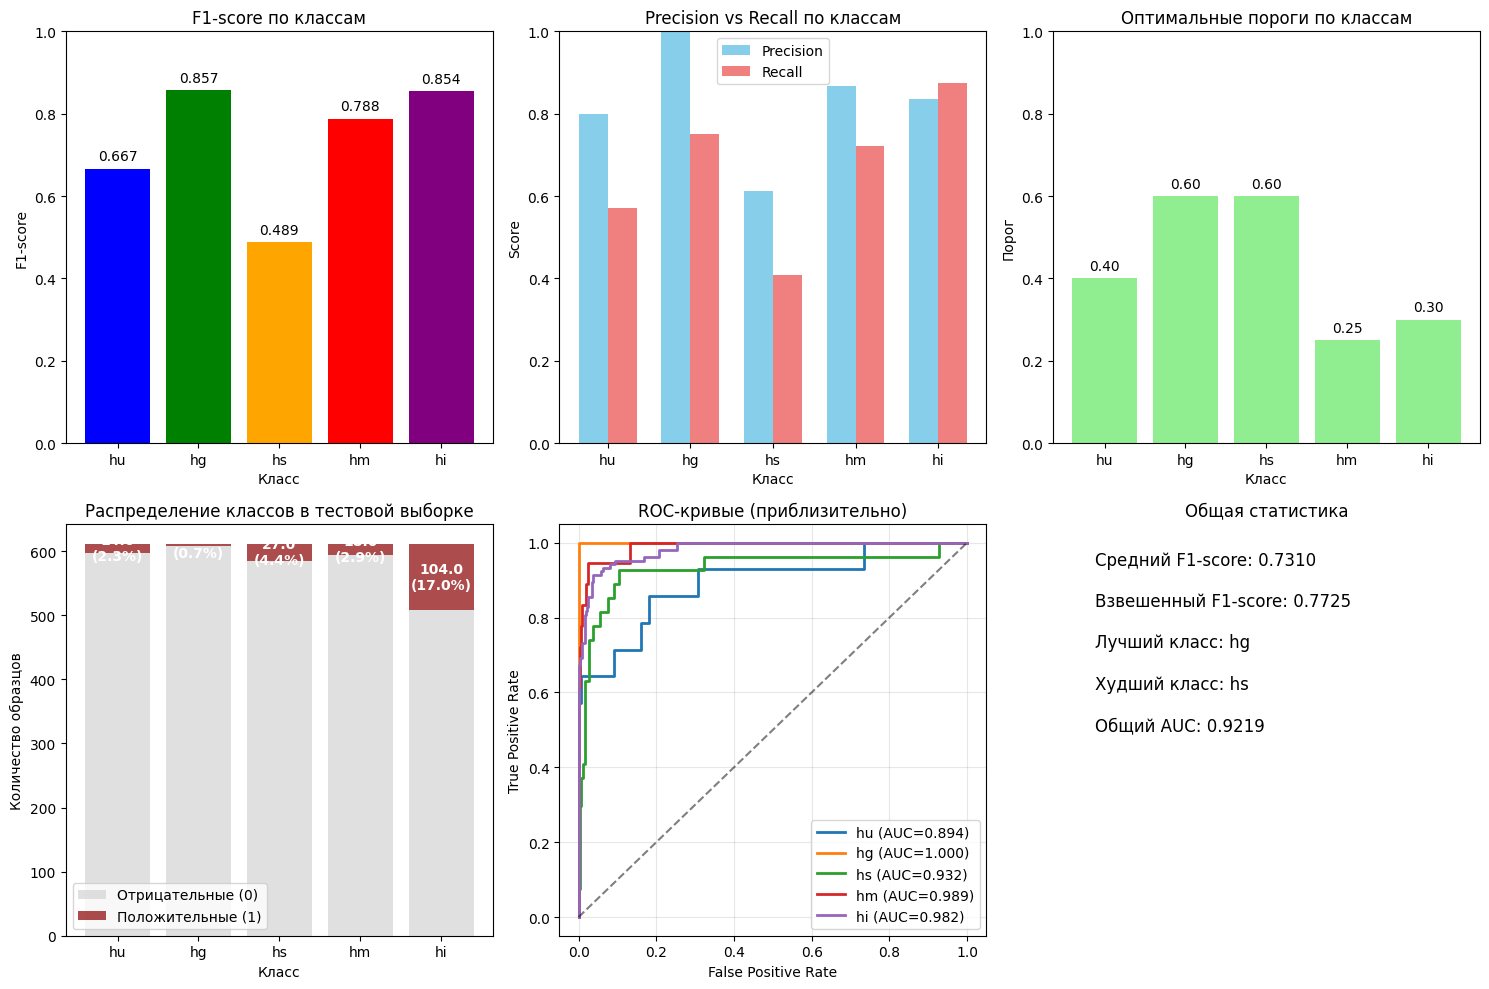


РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ

1. АНАЛИЗ РЕЗУЛЬТАТОВ:
----------------------------------------
✓ Средний F1-score: 0.7310
✓ Общий AUC: 0.9219

2. ПРОБЛЕМНЫЕ КЛАССЫ:
----------------------------------------
  hu: F1=0.6667
   • Положительных примеров: 14.0
   • Precision: 0.8000, Recall: 0.5714
  hs: F1=0.4889
   • Положительных примеров: 27.0
   • Precision: 0.6111, Recall: 0.4074

АНАЛИЗ ОШИБОК ПРЕДСКАЗАНИЙ

hu:
  Ложных срабатываний: 2 (0.3% от негативных)
  Пропущенных случаев: 6 (42.9% от позитивных)
  Пропущенных случаев: 1 (25.0% от позитивных)

hs:
  Ложных срабатываний: 7 (1.2% от негативных)
  Пропущенных случаев: 16 (59.3% от позитивных)

hm:
  Ложных срабатываний: 2 (0.3% от негативных)
  Пропущенных случаев: 5 (27.8% от позитивных)

hi:
  Ложных срабатываний: 18 (3.5% от негативных)
  Пропущенных случаев: 13 (12.5% от позитивных)

ФИНАЛЬНЫЕ ВЫВОДЫ

 Модель успешно обучена!
 Лучший валидационный F1-score: 0.8522
 Средний тестовый F1-score: 0.7310
 Лучшая эпоха: 84


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ==================== АНАЛИЗ РЕЗУЛЬТАТОВ ====================
print("\n" + "="*50)
print("АНАЛИЗ ИТОГОВЫХ РЕЗУЛЬТАТОВ")
print("="*50)

# Предсказания с оптимальными порогами
y_pred_proba = model.predict(X_test_cnn, verbose=0)

optimal_thresholds = [0.40, 0.60, 0.60, 0.25, 0.30]
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

results_summary = []

for i, (name, threshold) in enumerate(zip(class_names, optimal_thresholds)):
    y_true = y_test[:, i]
    y_pred = (y_pred_proba[:, i] > threshold).astype(int)
    
    # Метрики
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    results_summary.append({
        'name': name,
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'pos_count': y_true.sum(),
        'neg_count': len(y_true) - y_true.sum()
    })
    
    print(f"\n{name}:")
    print(f"  Порог: {threshold:.2f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  TP/FP/FN: {tp}/{fp}/{fn}")

# ==================== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ====================

# 1. Сравнение F1-scores
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# F1-score по классам
f1_scores = [r['f1'] for r in results_summary]
class_labels = [r['name'] for r in results_summary]

axes[0].bar(class_labels, f1_scores, color=['blue', 'green', 'orange', 'red', 'purple'])
axes[0].set_title('F1-score по классам')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# Precision vs Recall
precision_scores = [r['precision'] for r in results_summary]
recall_scores = [r['recall'] for r in results_summary]

x = np.arange(len(class_labels))
width = 0.35
axes[1].bar(x - width/2, precision_scores, width, label='Precision', color='skyblue')
axes[1].bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral')
axes[1].set_title('Precision vs Recall по классам')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_labels)
axes[1].legend()
axes[1].set_ylim(0, 1)

# Оптимальные пороги
thresholds = [r['threshold'] for r in results_summary]
axes[2].bar(class_labels, thresholds, color='lightgreen')
axes[2].set_title('Оптимальные пороги по классам')
axes[2].set_xlabel('Класс')
axes[2].set_ylabel('Порог')
axes[2].set_ylim(0, 1)
for i, v in enumerate(thresholds):
    axes[2].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Распределение классов
pos_counts = [r['pos_count'] for r in results_summary]
neg_counts = [r['neg_count'] for r in results_summary]

axes[3].bar(class_labels, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
axes[3].bar(class_labels, pos_counts, bottom=neg_counts, label='Положительные (1)', color='darkred', alpha=0.7)
axes[3].set_title('Распределение классов в тестовой выборке')
axes[3].set_xlabel('Класс')
axes[3].set_ylabel('Количество образцов')
axes[3].legend()
for i, (pos, neg) in enumerate(zip(pos_counts, neg_counts)):
    total = pos + neg
    axes[3].text(i, neg + pos/2, f'{pos}\n({pos/total*100:.1f}%)', 
                ha='center', va='center', color='white', fontweight='bold')

# Матрица ошибок (обобщенная)
conf_matrix_data = []
for r in results_summary:
    conf_matrix_data.append([r['tn'], r['fp']])
    conf_matrix_data.append([r['fn'], r['tp']])

# Визуализация ROC-кривых (приблизительно)
from sklearn.metrics import roc_curve, auc

axes[4].set_title('ROC-кривые (приблизительно)')
for i, name in enumerate(class_names):
    y_true = y_test[:, i]
    y_prob = y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    axes[4].plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})', linewidth=2)

axes[4].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].legend(loc='lower right')
axes[4].grid(True, alpha=0.3)

# Общая статистика
avg_f1 = np.mean(f1_scores)
weighted_f1 = np.average(f1_scores, weights=pos_counts)

axes[5].text(0.1, 0.9, f'Средний F1-score: {avg_f1:.4f}', fontsize=12)
axes[5].text(0.1, 0.8, f'Взвешенный F1-score: {weighted_f1:.4f}', fontsize=12)
axes[5].text(0.1, 0.7, f'Лучший класс: {class_labels[np.argmax(f1_scores)]}', fontsize=12)
axes[5].text(0.1, 0.6, f'Худший класс: {class_labels[np.argmin(f1_scores)]}', fontsize=12)
axes[5].text(0.1, 0.5, f'Общий AUC: {test_results[3]:.4f}', fontsize=12)
axes[5].axis('off')
axes[5].set_title('Общая статистика')

plt.tight_layout()
plt.show()

# ==================== РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ ====================
print("\n" + "="*50)
print("РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ")
print("="*50)

print("\n1. АНАЛИЗ РЕЗУЛЬТАТОВ:")
print("-" * 40)
print(f"✓ Средний F1-score: {avg_f1:.4f}")
print(f"✓ Общий AUC: {test_results[3]:.4f}")

print("\n2. ПРОБЛЕМНЫЕ КЛАССЫ:")
print("-" * 40)
for i, r in enumerate(results_summary):
    if r['f1'] < 0.7:
        print(f"  {r['name']}: F1={r['f1']:.4f}")
        print(f"   • Положительных примеров: {r['pos_count']}")
        print(f"   • Precision: {r['precision']:.4f}, Recall: {r['recall']:.4f}")

# ==================== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КОНФУЗИЙ ====================
print("\n" + "="*50)
print("АНАЛИЗ ОШИБОК ПРЕДСКАЗАНИЙ")
print("="*50)

# Анализ ложных срабатываний
for i, r in enumerate(results_summary):
    if r['fp'] > 0:
        fp_rate = r['fp'] / (r['fp'] + r['tn'])
        print(f"\n{r['name']}:")
        print(f"  Ложных срабатываний: {r['fp']} ({fp_rate*100:.1f}% от негативных)")
    
    if r['fn'] > 0:
        fn_rate = r['fn'] / (r['fn'] + r['tp'])
        print(f"  Пропущенных случаев: {r['fn']} ({fn_rate*100:.1f}% от позитивных)")



# ==================== ФИНАЛЬНЫЕ ВЫВОДЫ ====================
print("\n" + "="*50)
print("ФИНАЛЬНЫЕ ВЫВОДЫ")
print("="*50)

print(f"\n Модель успешно обучена!")
print(f" Лучший валидационный F1-score: {max(history.history['val_f1_score']):.4f}")
print(f" Средний тестовый F1-score: {avg_f1:.4f}")

# Анализ прогресса обучения
best_epoch = np.argmax(history.history['val_f1_score']) + 1
print(f" Лучшая эпоха: {best_epoch}")
